In [64]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs
import random
import os
import time

from torch.optim.lr_scheduler import ReduceLROnPlateau


plt.rcParams.update({'font.size':18})

In [66]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

In [67]:
# 导入数据
data = scipy.io.loadmat('udata3.mat')

U0 = data['U0']  # (16641, 129)
V0 = data['V0']  # (16641, 129)
P0 = data['P0']  # (4225, 65)

U = data['U']  # (65, 65, 129)
V = data['V'] # (65, 65, 129)
P = data['P'] # (65, 65, 129)

x_star = np.linspace(0, 1, 65).reshape((-1,1))
y_star = np.linspace(0, 1, 65).reshape((-1,1))
t_star = np.linspace(0,1,129).reshape((-1,1))
xx, yy = np.meshgrid(x_star,y_star)
X_star = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)

N = X_star.shape[0]
T = len(t_star)
# print(X_star[:,0].shape)

XX = np.tile(X_star[:,0:1], (1,T)) # N,T
YY = np.tile(X_star[:,1:2], (1,T)) # N,T
TT = np.tile(t_star, (1,N)).T # N,T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = U.flatten()[:, None]  # NT x 1
v = V.flatten()[:, None]  # NT x 1
p = P.flatten()[:, None]  # NT x 1

# X_star,xx
x.shape
N,T

(4225, 129)

## 检验数据

(65, 65)


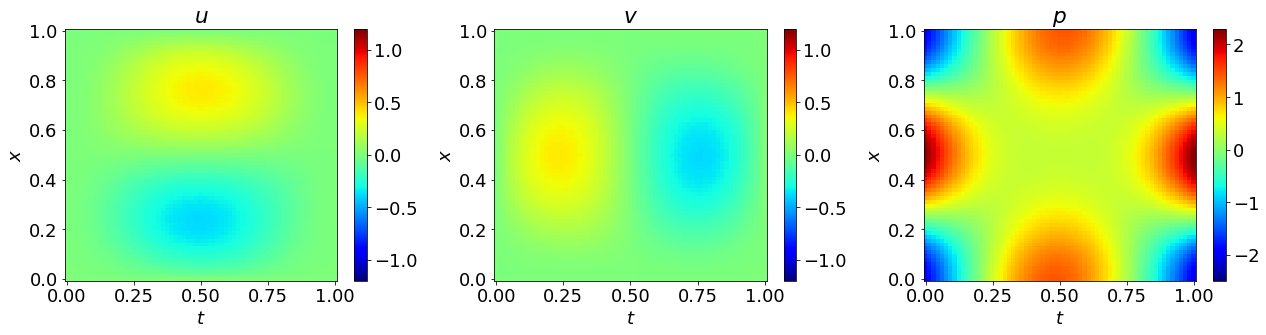

In [68]:
NS_u = U[:,:,100]
NS_v = V[:,:,100]
NS_p = P[:,:,100]

# u = NS_u.flatten()[:, None]
# v = NS_v.flatten()[:, None]
# p = NS_p.flatten()[:, None]

print(NS_u.shape)

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_u.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([u.min(),u.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$u$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_v.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([v.min(),v.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$v$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_p.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([p.min(),p.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$p$')
plt.tight_layout()

## 超参数

In [69]:
domain = (0,1,0,1,0,10)
xmin , xmax ,ymin,ymax,tmin,tmax = domain
backbone_layers = [3] + [20]*6 + [2]
nn_nu_layers = [1] +[20]*4 + [1]
N_train = 5000
adam_iters = 10000
# adam_iters = 200000
gamma = 0.6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [70]:
class DatasetNS:
    def __init__(self, domain):
        self.domain = domain

    def train_data(self, N_train, verbose=None):
        xmin, xmax, ymin, ymax, tmin, tmax = domain
        
        idx = np.random.choice(N * T, N_train, replace=False)
        x_train = x[idx, :]
        y_train = y[idx, :]
        t_train = t[idx, :]
        u_train = u[idx, :]
        v_train = v[idx, :]
        p_train = p[idx, :]

        return x_train, y_train, t_train, u_train, v_train, p_train
    

dataset = DatasetNS(domain)
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
print(x_train.shape, y_train.shape, t_train.shape, u_train.shape, v_train.shape, p_train.shape)

(5000, 1) (5000, 1) (5000, 1) (5000, 1) (5000, 1) (5000, 1)


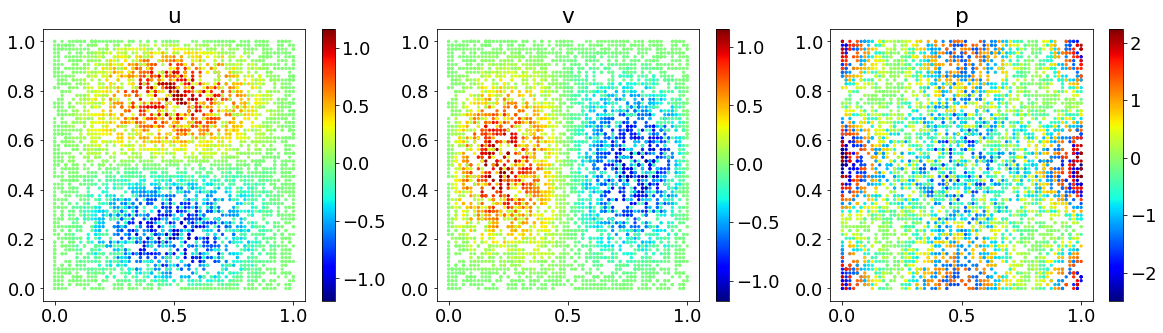

In [71]:
# 随即采样真实数据
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
plt.scatter(x_train, y_train, c=u_train, s=5, cmap='jet')
plt.title("u")
plt.colorbar()

plt.subplot(1,3,2)
plt.scatter(x_train, y_train, c=v_train, s=5, cmap='jet')
plt.title("v")
plt.colorbar()

plt.subplot(1,3,3)
plt.scatter(x_train, y_train, c=p_train, s=5, cmap='jet')
plt.title("p")
plt.colorbar()

In [72]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)


backbone = MLP(backbone_layers)
nn_nu = MLP(nn_nu_layers)

## PINN模型

In [73]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [74]:
"""PINN模型"""
class PINNNS(nn.Module):
    def __init__(self, backbone, nn_nu, mu=None, sigma=None):
        super(PINNNS, self).__init__()
        self.backbone = backbone
        self.nn_nu = nn_nu
        self.nu = torch.tensor([1.0], requires_grad=True)

        self.nu = torch.nn.Parameter(self.nu)

        self.backbone = MLP(backbone_layers).to(device)
        self.nn_nu = MLP(nn_nu_layers).to(device)

        self.backbone.register_parameter('nu', self.nu)
        self.nn_nu.register_parameter('nu', self.nu)
        
        self.dataset = DatasetNS(domain)
        
        self.bound = 0.01
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False

    def forward(self,X_res, u_star, v_star,p_star):
        f_u, f_v, u, v, p = self.net_NS(X_res)
        loss_u_data = torch.mean(f_u ** 2)
        loss_v_data = torch.mean(f_v ** 2)
        loss_u_res = torch.mean((u_star - u) ** 2)
        loss_v_res = torch.mean((v_star - v) ** 2)
        loss_p_res = torch.mean((p_star - p) ** 2)

        return loss_u_data, loss_v_data, loss_u_res, loss_v_res, loss_p_res
    
    def update_train_data(self):
        """更新采样点"""
        self.x, self.y, self.t, self.u, self.v, self.p = self.dataset.train_data(N_train)
        
        
    def net_u(self,X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
        # return self.backbone(X_res)

    def net_nu(self,X):
#         if self.is_inputs_normalization == True:
#             X = (X - self.mu) / self.sigma
        return self.nn_nu(X) * 5e-2

    def net_NS(self,X_res):
        X_res.requires_grad_(True)

        pred = self.net_u(X_res)
        psi = pred[:,[0]].reshape(-1, 1)
        p = pred[:,[1]].reshape(-1, 1)
        
        psi.requires_grad_(True)
        p.requires_grad_(True)

        grad_psi = grad(psi,X_res)[0]
        u = grad_psi[:, [1]]
        v = - grad_psi[:, [0]]

        grad_u = grad(u, X_res)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_t = grad_u[:, [2]]
        u_xx = grad(u_x, X_res)[0][:, [0]]
        u_yy = grad(u_y, X_res)[0][:, [1]]
        
        grad_v = grad(v, X_res)[0]
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        v_t = grad_v[:, [2]]
        v_xx = grad(v_x, X_res)[0][:, [0]]
        v_yy = grad(v_y, X_res)[0][:, [1]]
        
        grad_p = grad(p, X_res)[0]
        p_x = grad_p[:, [0]]
        p_y = grad_p[:, [1]]

        # nu = self.nu
        nu = self.net_nu(X_res[:,[2]])

        f_u = u_t + u*u_x + v*u_y + p_x - nu * (u_xx + u_yy)
        f_v = v_t + u*v_x + v*v_y + p_y - nu * (v_xx + v_yy)
        return f_u, f_v, u, v, p

pinn = PINNNS(backbone, nn_nu)

## Adam优化

In [75]:
"""Adam优化"""
dataset = DatasetNS(domain)  # 生成训练数据
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
t_train = torch.from_numpy(t_train).float().to(device)
u_train = torch.from_numpy(u_train).float().to(device)
v_train = torch.from_numpy(v_train).float().to(device)
p_train = torch.from_numpy(p_train).float().to(device)

X_res = torch.cat([x_train,y_train,t_train], dim=1)
# X_res = np.concatenate([x, y, t],1)
# X_res = torch.tensor(X_res)
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_nu = MLP(nn_nu_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_nu, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)
optimizer_adam_nu = optim.Adam(pinn.nn_nu.parameters(), lr=1e-3)

# lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率
# lr_sche_lam = optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.9)

lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
lr_sche_nu = ReduceLROnPlateau(optimizer_adam_nu, mode='min', factor=gamma, verbose=True)
logger = {
    "loss": [],
    "loss_u_res": [],
    "loss_v_res": [],
    "loss_p_res": [],
    "loss_u_data": [],
    "loss_v_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()

    loss_u_data, loss_v_data,loss_u_res, loss_v_res, loss_p_res = pinn(X_res,u_train,v_train, p_train)
    loss = (loss_u_data*100 + loss_v_data*100 + loss_u_res + loss_v_res + loss_p_res) 

    loss.backward()
    optimizer_adam.step()
    optimizer_adam_nu.step()
    # 计算loss并更新网络 -------

    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_u_data_valid, loss_v_data_valid, loss_u_res_valid, loss_v_res_valid, loss_p_res_valid = pinn(X_res,u_train,v_train,p_train)
        loss_valid = loss_u_data_valid + loss_v_data_valid + loss_u_res_valid + loss_v_res_valid + loss_p_res_valid

        logger["loss"].append(loss_valid.item())
        logger["loss_u_res"].append(loss_u_res_valid.item())
        logger["loss_v_res"].append(loss_v_res_valid.item())
        logger["loss_p_res"].append(loss_p_res_valid.item())
        logger["loss_u_data"].append(loss_u_data_valid.item())
        logger["loss_v_data"].append(loss_v_data_valid.item())
        logger["iter"].append(it + 1)

        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it + 1, 'backbone_state': pinn.backbone.state_dict(),
                           'nn_nu_state': pinn.nn_nu.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()

        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it + 1:6d}/{adam_iters}\t' + \
                   f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, loss_p_r:{loss_p_res.item():.2e}, loss_u_d:{loss_u_data.item():.2e} ,loss_v_d:{loss_v_data.item():.2e} ' + \
                   f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_u_res_valid.item():.2e}, loss_r:{loss_v_res_valid.item():.2e}, loss_u_d:{loss_u_data_valid.item():.2e}, loss_v_d:{loss_v_data_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
        pinn.update_train_data()

        # 衰减学习率
        if (it + 1) % 2000 == 0:
            lr_sche.step(loss)
            lr_sche_nu.step(loss)

forward with normalization, mu=[0.5029749870300293, 0.5015624761581421, 0.5004781484603882], sigma=[0.2930244207382202, 0.2936508357524872, 0.29021671414375305]
Iter #    500/10000	loss:8.31e-01, loss_u_r:6.60e-02, loss_v_r:6.85e-02, loss_p_r:6.86e-01, loss_u_d:4.02e-05 ,loss_v_d:5.89e-05 Valid # loss:8.21e-01, loss_r:6.60e-02, loss_r:6.85e-02, loss_u_d:4.07e-05, loss_v_d:5.90e-05
Iter #   1000/10000	loss:8.07e-01, loss_u_r:5.76e-02, loss_v_r:5.90e-02, loss_p_r:6.81e-01, loss_u_d:4.94e-05 ,loss_v_d:5.18e-05 Valid # loss:7.97e-01, loss_r:5.76e-02, loss_r:5.90e-02, loss_u_d:4.88e-05, loss_v_d:4.39e-05
Iter #   1500/10000	loss:7.87e-01, loss_u_r:4.91e-02, loss_v_r:5.08e-02, loss_p_r:6.76e-01, loss_u_d:6.38e-05 ,loss_v_d:4.71e-05 Valid # loss:7.76e-01, loss_r:4.91e-02, loss_r:5.09e-02, loss_u_d:7.63e-05, loss_v_d:4.86e-05
Iter #   2000/10000	loss:7.65e-01, loss_u_r:4.01e-02, loss_v_r:4.19e-02, loss_p_r:6.71e-01, loss_u_d:6.52e-05 ,loss_v_d:5.46e-05 Valid # loss:7.53e-01, loss_r:4.01e-02, l

In [76]:
np.save("./logger.npy", logger)
model_state

{'iter': 10000,
 'backbone_state': OrderedDict([('nu', tensor([1.])),
              ('model.layer0.fc0.weight',
               tensor([[-4.1816e-01,  4.7656e-01, -1.4892e-02],
                       [-6.8459e-02, -5.0438e-01,  8.1002e-02],
                       [ 6.2597e-01,  2.1261e-01, -1.6641e-02],
                       [ 6.5259e-01, -3.4667e-01, -3.7634e-02],
                       [ 1.4561e-01,  4.0147e-02,  6.5512e-05],
                       [-4.3625e-01, -7.8892e-02, -2.7446e-01],
                       [-1.2731e-02,  2.1948e-03, -5.4432e-01],
                       [ 1.3125e-01, -3.9351e-01, -1.6132e-01],
                       [-1.5325e-01,  1.3008e-01, -1.0115e-01],
                       [-3.4003e-01, -2.1738e-01, -2.3085e-01],
                       [ 1.1326e-01, -6.8791e-01, -6.6198e-03],
                       [ 3.6408e-01,  4.8957e-01,  6.5176e-03],
                       [-2.0951e-01,  4.6353e-01, -5.2805e-02],
                       [ 4.9343e-01,  1.2640e-01,  5.574

## LBFGS

In [77]:
"""LBFGS训练"""
start_time = time.time()

dataset = DatasetNS(domain)  # 生成训练数据
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
t_train = torch.from_numpy(t_train).float().to(device)
u_train = torch.from_numpy(u_train).float().to(device)
v_train = torch.from_numpy(v_train).float().to(device)
p_train = torch.from_numpy(p_train).float().to(device)

# X_res = np.concatenate([x, y, t],1)
# X_res = torch.tensor(X_res)
X_res = torch.cat([x_train,y_train,t_train], dim=1)
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_nu = MLP(nn_nu_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_nu, mu, sigma).to(device)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_nu.load_state_dict(model_state['nn_nu_state'])

optimizer_lbfgs = optim.LBFGS(pinn.backbone.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)
optimizer_lbfgs_lam = optim.LBFGS(pinn.nn_nu.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)

loss_log_lbfgs = []
it = 0
with open(train_info_path + 'train_info.txt', 'a') as f:
    f.write('Training by LBFGS:\n')
logger_lbfgs = {
    "loss": [],
    "loss_u_res": [],
    "loss_v_res": [],
    "loss_p_res": [],
    "loss_u_data": [],
    "loss_v_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}

def closure():
    global it
    pinn.zero_grad()
    loss_u_data,loss_v_data,loss_u_res,loss_v_res, loss_p_res = pinn(X_res, u_train, v_train,p_train)
    loss = (1000*loss_u_data + 1000*loss_v_data + loss_u_res + loss_v_res + loss_p_res) 
    loss.backward()
    it = it + 1
    loss_log_lbfgs.append(loss.item())
    if (it + 1) % 100 == 0:
        pinn.train(False)
        loss_u_data_valid, loss_v_data_valid, loss_u_res_valid, loss_v_res_valid, loss_p_res_valid = pinn(X_res,u_train,v_train,p_train)
        loss_valid = loss_u_data_valid + loss_v_data_valid + loss_u_res_valid + loss_v_res_valid + loss_p_res_valid

        logger_lbfgs["loss"].append(loss_valid.item())
        logger_lbfgs["loss_u_res"].append(loss_u_res_valid.item())
        logger_lbfgs["loss_v_res"].append(loss_v_res_valid.item())
        logger_lbfgs["loss_p_res"].append(loss_p_res_valid.item())
        logger_lbfgs["loss_u_data"].append(loss_u_data_valid.item())
        logger_lbfgs["loss_v_data"].append(loss_v_data_valid.item())
        logger_lbfgs["iter"].append(it + 1)
        
        info = f'Iter # {it + 1:4d}\ttime:{time.time() - start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, loss_p_r:{loss_p_res.item():.2e}, loss_u_d:{loss_u_data.item():2e}, loss_v_d:{loss_v_data.item():2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
    return loss

optimizer_lbfgs.step(closure)
optimizer_lbfgs_lam.step(closure)

model_state = {'backbone_state': pinn.backbone.state_dict(), 'nn_nu_state': pinn.nn_nu.state_dict()}
backbone_path = os.path.join(model_path, f'pinn_lbfgs.pth')
torch.save(model_state, backbone_path)

forward with normalization, mu=[0.5012531280517578, 0.5026500225067139, 0.5076640844345093], sigma=[0.29328712821006775, 0.295980304479599, 0.2893267571926117]
Iter #  100	time:21.1	loss:7.17e-01, loss_u_r:7.29e-03, loss_v_r:7.36e-03, loss_p_r:6.79e-01, loss_u_d:1.252811e-05, loss_v_d:1.092799e-05
Iter #  200	time:44.4	loss:7.11e-01, loss_u_r:8.19e-03, loss_v_r:8.21e-03, loss_p_r:6.80e-01, loss_u_d:7.971130e-06, loss_v_d:7.316337e-06
Iter #  300	time:68.2	loss:7.08e-01, loss_u_r:7.79e-03, loss_v_r:7.84e-03, loss_p_r:6.79e-01, loss_u_d:6.860925e-06, loss_v_d:6.377451e-06
Iter #  400	time:88.9	loss:7.04e-01, loss_u_r:7.04e-03, loss_v_r:7.03e-03, loss_p_r:6.78e-01, loss_u_d:6.325301e-06, loss_v_d:5.936119e-06
Iter #  500	time:118.0	loss:7.00e-01, loss_u_r:6.22e-03, loss_v_r:6.26e-03, loss_p_r:6.77e-01, loss_u_d:5.491986e-06, loss_v_d:5.087513e-06
Iter #  600	time:143.4	loss:6.97e-01, loss_u_r:6.04e-03, loss_v_r:6.12e-03, loss_p_r:6.76e-01, loss_u_d:4.581383e-06, loss_v_d:4.489786e-06
Iter

In [78]:
np.save("./logger.npy", logger)
np.save("./logger_lbfgs.npy", logger_lbfgs)
model_state

{'backbone_state': OrderedDict([('nu', tensor([1.])),
              ('model.layer0.fc0.weight',
               tensor([[-2.6682e-01,  2.7031e-01,  4.4341e-04],
                       [-3.1574e-02, -3.5581e-01,  1.5443e-02],
                       [ 3.5881e-01,  1.1757e-01, -7.8977e-03],
                       [ 3.5613e-01, -1.4791e-01, -2.1526e-02],
                       [ 4.7931e-02,  8.3263e-02, -1.0817e-02],
                       [-2.7627e-01, -5.7181e-02, -8.1986e-02],
                       [ 4.3020e-03, -7.5788e-03, -5.4255e-01],
                       [ 4.3689e-02, -2.2060e-01, -7.7671e-02],
                       [-7.2680e-02,  5.7908e-02, -1.6051e-02],
                       [-1.5348e-01, -1.4893e-01, -5.7371e-02],
                       [ 1.1669e-01, -3.8711e-01,  5.6906e-03],
                       [ 2.3251e-01,  2.9389e-01,  1.7647e-03],
                       [-1.5909e-01,  3.4837e-01, -5.3148e-02],
                       [ 2.7725e-01,  6.9974e-02,  2.8577e-02],
        

## 结果可视化

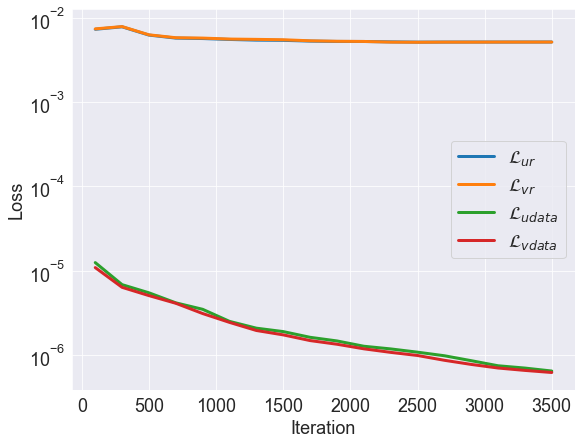

In [79]:
logger = np.load("./logger.npy", allow_pickle=True).item()
logger_lbfgs = np.load("./logger_lbfgs.npy", allow_pickle=True).item()
logger = dict(list(logger.items()) + list(logger_lbfgs.items()))
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["loss_u_res"][::k], label=r"$\mathcal{L}_{ur}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_v_res"][::k], label=r"$\mathcal{L}_{vr}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_u_data"][::k], label=r"$\mathcal{L}_{udata}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_v_data"][::k], label=r"$\mathcal{L}_{vdata}$", linewidth=3)
    plt.legend()
#     plt.xticks([0, 10000, 20000,30000,40000])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

In [80]:
# # # 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

# mu = X_res.mean(dim=0)
# sigma = X_res.std(dim=0)

backbone = MLP(backbone_layers)  # 主干网络
nn_nu = MLP(nn_nu_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_nu, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
# model_state = torch.load(os.path.join(model_path, 'pinn_lbfgs.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_nu.load_state_dict(model_state['nn_nu_state'])
pinn.eval()

data = scipy.io.loadmat('udata3.mat')

U0 = data['U0']  # (16641, 129)
V0 = data['V0']  # (16641, 129)
P0 = data['P0']  # (4225, 65)

U = data['U']  # (65, 65, 129)
V = data['V'] # (65, 65, 129)
P = data['P'] # (65, 65, 129)

x_star = np.linspace(0, 1, 65).reshape((-1,1))
y_star = np.linspace(0, 1, 65).reshape((-1,1))
t_star = np.linspace(0,1,129).reshape((-1,1))
xx, yy = np.meshgrid(x_star,y_star)
X_star = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)

N = X_star.shape[0]
T = t_star.shape[0]

XX = np.tile(xx, (1,T)) # N,T
YY = np.tile(yy, (1,T)) # N,T
TT = np.tile(t_star, (1,N)).T # N,T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = U.flatten()[:, None]  # NT x 1
v = V.flatten()[:, None]  # NT x 1
p = P.flatten()[:, None]  # NT x 1

x = torch.tensor(x)
y = torch.tensor(y)
t = torch.tensor(t)

pinn = pinn.cpu().double()
# lam1_star = 1
# lam2_star = 0.01

t_star.shape,N,T
# U[:,:,100]
TT.shape

forward with normalization, mu=[0.5012531280517578, 0.5026500225067139, 0.5076640844345093], sigma=[0.29328712821006775, 0.295980304479599, 0.2893267571926117]


(4225, 129)

In [81]:
model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_nu.load_state_dict(model_state['nn_nu_state'])

snap = np.array([50])
# x_star = X_star[:, 0:1]
# y_star = X_star[:, 1:2]
# t_star = TT[:,snap]

# u_star = U[:, :, snap]
# v_star = V[:, :, snap]
# p_star = P[:,:,snap]

# Prediction
# x_star = torch.tensor(x_star)
# y_star = torch.tensor(y_star)
# t_star = torch.tensor(t_star)
# u_star = torch.tensor(u_star.flatten()[:, None])
# v_star = torch.tensor(v_star.flatten()[:, None])
# p_star = torch.tensor(p_star.flatten()[:, None])

# X = torch.cat([x_star,y_star,t_star], dim=1)

N_test = 20000
dataset = DatasetNS(domain)  # 生成训练数据
x_test, y_test, t_test, u_test, v_test, p_test = dataset.train_data(N_test)
print(t_test)
# x_test = torch.from_numpy(x_test).float().to(device)
# y_test = torch.from_numpy(y_test).float().to(device)
# t_test = torch.from_numpy(t_test).float().to(device)
# u_test = torch.from_numpy(u_test).float().to(device)
# v_test = torch.from_numpy(v_test).float().to(device)
# p_test = torch.from_numpy(p_test).float().to(device)

X = torch.cat([x_test,y_test,t_test], dim=1)
X_res = pinn.net_NS(X)
nu_pred = pinn.net_nu(t_test)
nu_pred = torch.tensor(nu_pred)

tensor([[0.9219],
        [0.5156],
        [0.5469],
        ...,
        [0.6250],
        [0.8125],
        [0.2031]], dtype=torch.float64)


<ipython-input-81-75fea52e6299>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nu_pred = torch.tensor(nu_pred)


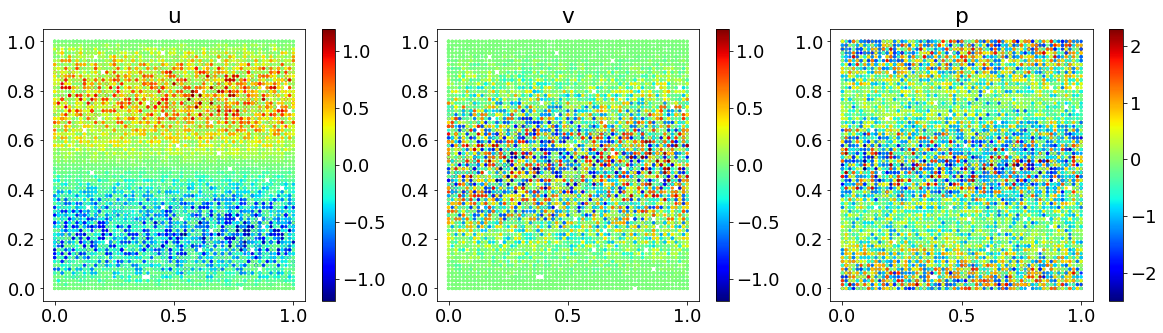

In [82]:
# 随即采样真实数据
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
plt.scatter(x_test, y_test, c=u_test, s=5, cmap='jet')
plt.title("u")
plt.colorbar()

plt.subplot(1,3,2)
plt.scatter(x_test, y_test, c=v_test, s=5, cmap='jet')
plt.title("v")
plt.colorbar()

plt.subplot(1,3,3)
plt.scatter(x_test, y_test, c=p_test, s=5, cmap='jet')
plt.title("p")
plt.colorbar()

In [83]:
nu_pred.shape,t_test.shape

(torch.Size([20000, 1]), torch.Size([20000, 1]))

In [84]:
nu_pred.min(),nu_pred.max()

(tensor(0.0052, dtype=torch.float64), tensor(0.0394, dtype=torch.float64))

In [85]:
nu_star = np.ones(t_test.shape)*0.01
for i in range(len(nu_star)):
    if t_test[i]>=0.5:
        nu_star[i]=0.03


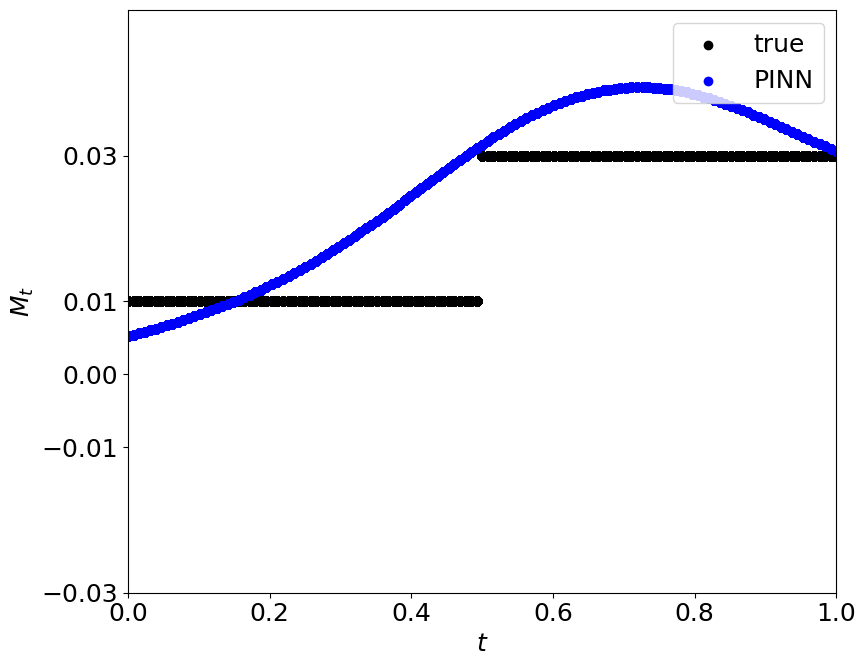

In [97]:
fig, ax = plt.subplots(figsize=(9, 7), dpi=100)
# ax.plot(t_test, nu_star, linewidth=3, linestyle='--', color='black', label='true')
# ax.plot(t_test, nu_pred, linewidth=3, linestyle='--', color='blue', label='PINN')
ax.scatter(t_test, nu_star, color='black', label='true')
ax.scatter(t_test, nu_pred, color='blue', label='PINN')
# ax.scatter(t[::30], M[::30], marker='^', s=120, color='blue', label='cS-PINN')
ax.set_xlim([0, 1])
# ax.set_xticks(np.arange(0, 1.1, 2))
ax.set_xlabel('$t$')
ax.set_ylim([-0.03, 0.05])
ax.set_yticks([-0.03, -0.01, 0, 0.01, 0.03])
ax.set_ylabel('$M_t$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("./M.png", dpi=100)
plt.show()

## 计算error

In [87]:
"""计算error"""
u_pred = torch.tensor(X_res[2])
v_pred = torch.tensor(X_res[3])
p_pred = torch.tensor(X_res[4])

u_pred =u_pred.flatten()[:, None].detach().cpu().numpy()
v_pred =v_pred.flatten()[:, None].detach().cpu().numpy()
p_pred =p_pred.flatten()[:, None].detach().cpu().numpy()  
nu_pred = nu_pred.flatten()[:, None].detach().cpu().numpy() 
# lam1_pred = pinn.lam1.detach().cpu().numpy()
# lam2_pred = pinn.lam2.detach().cpu().numpy()

print('lam1_pred:',nu_pred)
# print('lam2_pred:',lam2_pred)
print('u_star:',u_test)
print('u_pred:',u_pred)
print('v_star:',v_test)
print('v_pred:',v_pred)
print('p_star:',p_test)
print('p_pred:',p_pred)

# Error
# error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
# error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
# error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_u = np.linalg.norm(u_test - u_pred, 2) / np.linalg.norm(u_test, 2)
error_v = np.linalg.norm(v_test - v_pred, 2) / np.linalg.norm(v_test, 2)
error_p = np.linalg.norm(p_test - p_pred, 2) / np.linalg.norm(p_test, 2)

error_nu = np.linalg.norm(nu_star - nu_pred, 2) / np.linalg.norm(nu_star, 2)
# error_nu = np.abs(nu_pred - nu_star) /nu_star * 100
# error_lambda_2 = np.abs(lam2_pred - lam2_star) / lam2_star * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error nu: %e' % (error_nu))                             
# print('Error l1: %.5f%%' % (error_nu))                             
# print('Error l2: %.5f%%' % (error_lambda_2))  
print(u_pred.shape)
print(u_test.shape)

lam1_pred: [[0.03396314]
 [0.0325091 ]
 [0.03432881]
 ...
 [0.03777251]
 [0.03811488]
 [0.01232466]]
u_star: [[-0.01097488]
 [ 0.60725012]
 [-0.03007701]
 ...
 [-0.2604448 ]
 [ 0.34543112]
 [-0.17406226]]
u_pred: [[ 0.01147888]
 [ 0.47424759]
 [-0.18829963]
 ...
 [-0.30921029]
 [ 0.13041172]
 [ 0.04552632]]
v_star: [[-0.00691878]
 [ 0.57290771]
 [-0.0355524 ]
 ...
 [-0.02167156]
 [-0.0238625 ]
 [ 0.03033463]]
v_pred: [[ 0.0106969 ]
 [-0.52121624]
 [ 0.14988395]
 ...
 [-0.10562818]
 [ 0.21700992]
 [-0.03909045]]
p_star: [[-0.75834512]
 [ 0.12878439]
 [-0.84058659]
 ...
 [ 1.05463749]
 [ 0.67303326]
 [ 0.41075211]]
p_pred: [[ 0.05801586]
 [-0.18567589]
 [-0.02361206]
 ...
 [-0.01289508]
 [ 0.03564428]
 [-0.09961299]]
Error u: 7.562550e-01
Error v: 1.422297e+00
Error p: 9.705466e-01
Error nu: 3.763750e-01
(20000, 1)
(20000, 1)


<ipython-input-87-15b46061f710>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_pred = torch.tensor(X_res[2])
<ipython-input-87-15b46061f710>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_pred = torch.tensor(X_res[3])
<ipython-input-87-15b46061f710>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_pred = torch.tensor(X_res[4])


In [88]:
print(u_pred.shape)

(20000, 1)


In [89]:
u_pred.shape,xx.shape

((20000, 1), (65, 65))

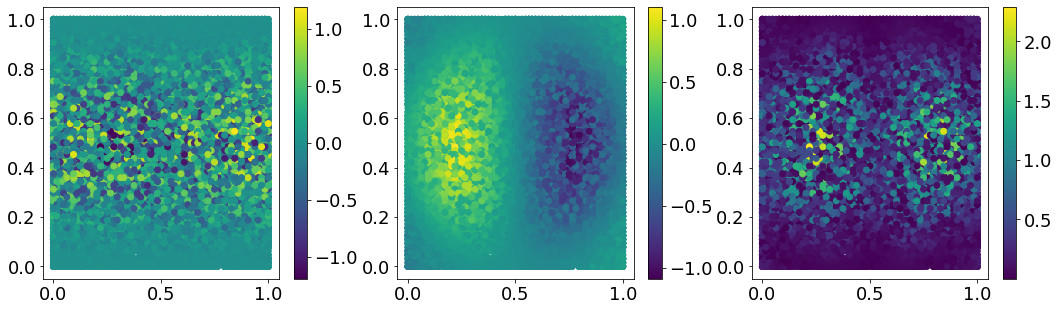

In [90]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(x_test,y_test,c=v_test)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(x_test,y_test,c=v_pred)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x_test,y_test,c=np.abs(v_pred-v_test))
plt.colorbar()

In [91]:
snap = np.array([100])
x_star = X_star[:, 0:1]
y_star = X_star[:, 1:2]
t_star = TT[:,snap]

u_star = U[:, :, snap]
v_star = V[:, :, snap]
p_star = P[:,:,snap]

#Prediction
x_star = torch.tensor(x_star)
y_star = torch.tensor(y_star)
t_star = torch.tensor(t_star)
u_star = torch.tensor(u_star.flatten()[:, None])
v_star = torch.tensor(v_star.flatten()[:, None])
p_star = torch.tensor(p_star.flatten()[:, None])

X = torch.cat([x_star,y_star,t_star], dim=1)
X_res = pinn.net_NS(X)

u_pred = torch.tensor(X_res[2])
v_pred = torch.tensor(X_res[3])
p_pred = torch.tensor(X_res[4])

u_pred = u_pred.flatten()[:, None].detach().cpu().numpy()
v_pred = v_pred.flatten()[:, None].detach().cpu().numpy()
p_pred = p_pred.flatten()[:, None].detach().cpu().numpy()  

u_star = u_star.detach().cpu().numpy()
v_star = v_star.detach().cpu().numpy()
p_star = p_star.detach().cpu().numpy()

xx, yy = np.meshgrid(x_star,y_star)
print(xx.shape)
print(u_pred.shape)
print(X_star.shape)
print(X.shape)

(4225, 4225)
(4225, 1)
(4225, 2)
torch.Size([4225, 3])


<ipython-input-91-ec1a1c1ca87b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_pred = torch.tensor(X_res[2])
<ipython-input-91-ec1a1c1ca87b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_pred = torch.tensor(X_res[3])
<ipython-input-91-ec1a1c1ca87b>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_pred = torch.tensor(X_res[4])


In [92]:
"""计算error"""

print('lam1_pred:',nu_pred)
# print('lam2_pred:',lam2_pred)
print('u_star:',u_test)
print('u_pred:',u_pred)
print('v_star:',v_test)
print('v_pred:',v_pred)
print('p_star:',p_test)
print('p_pred:',p_pred)

# Error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_nu = np.linalg.norm(nu_star - nu_pred, 2) / np.linalg.norm(nu_star, 2)
# error_nu = np.abs(nu_pred - nu_star) /nu_star * 100
# error_lambda_2 = np.abs(lam2_pred - lam2_star) / lam2_star * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error nu: %e' % (error_nu))                             
# print('Error l1: %.5f%%' % (error_nu))                             
# print('Error l2: %.5f%%' % (error_lambda_2))  
print(u_pred.shape)
print(u_test.shape)

lam1_pred: [[0.03396314]
 [0.0325091 ]
 [0.03432881]
 ...
 [0.03777251]
 [0.03811488]
 [0.01232466]]
u_star: [[-0.01097488]
 [ 0.60725012]
 [-0.03007701]
 ...
 [-0.2604448 ]
 [ 0.34543112]
 [-0.17406226]]
u_pred: [[ 0.07591765]
 [ 0.0700717 ]
 [ 0.06356344]
 ...
 [-0.06267689]
 [-0.06967685]
 [-0.07598958]]
v_star: [[-0.00691878]
 [ 0.57290771]
 [-0.0355524 ]
 ...
 [-0.02167156]
 [-0.0238625 ]
 [ 0.03033463]]
v_pred: [[-0.06561664]
 [-0.05868858]
 [-0.05144524]
 ...
 [ 0.06798878]
 [ 0.07796287]
 [ 0.08783199]]
p_star: [[-0.75834512]
 [ 0.12878439]
 [-0.84058659]
 ...
 [ 1.05463749]
 [ 0.67303326]
 [ 0.41075211]]
p_pred: [[0.03354089]
 [0.03345223]
 [0.03339549]
 ...
 [0.04317081]
 [0.04348355]
 [0.04383842]]
Error u: 4.323903e-01
Error v: 4.332895e-01
Error p: 1.021426e+00
Error nu: 3.763750e-01
(4225, 1)
(20000, 1)


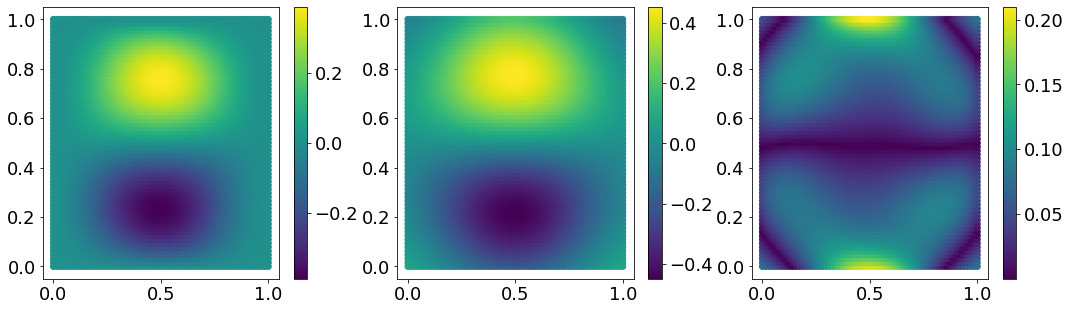

In [93]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(x_star,y_star,c=u_star)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(x_star,y_star,c=u_pred)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x_star,y_star,c=np.abs(u_pred-u_star))
plt.colorbar()

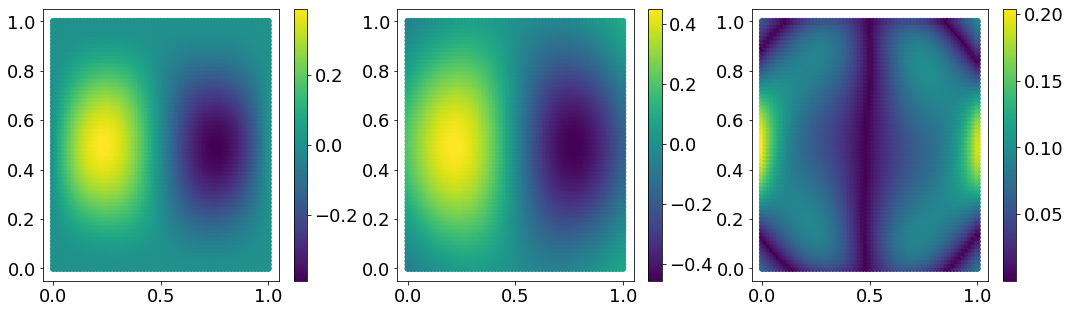

In [94]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(x_star,y_star,c=v_star)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(x_star,y_star,c=v_pred)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x_star,y_star,c=np.abs(v_pred-v_star))
plt.colorbar()

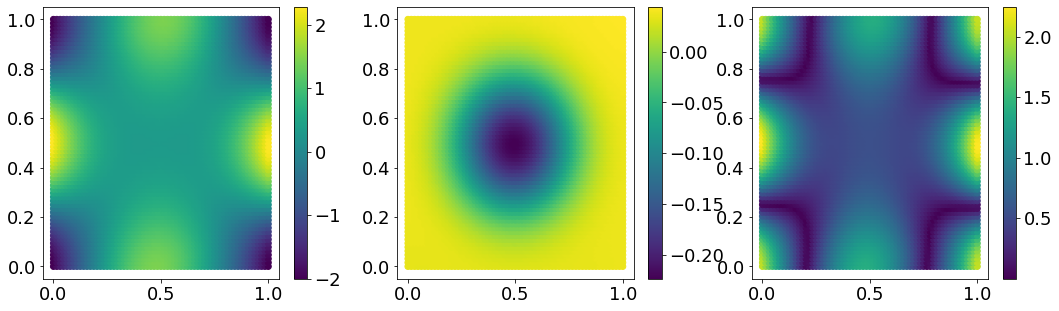

In [95]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(x_star,y_star,c=p_star)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(x_star,y_star,c=p_pred)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x_star,y_star,c=np.abs(p_pred-p_star))
plt.colorbar()

In [96]:
# fig = plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# # plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
# plt.colorbar()
# # plt.clim([u.min(),u.max()])
# plt.xlabel('$y$')
# plt.ylabel('$x$')
# plt.title(r'$u$')
# plt.tight_layout()

# plt.subplot(1, 3, 2)
# # plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
# plt.pcolor(xx, yy, v_pred.reshape(xx.shape), cmap='jet')
# plt.colorbar()
# # plt.clim([v.min(),v.max()])
# plt.xlabel('$y$')
# plt.ylabel('$x$')
# plt.title(r'$v$')
# plt.tight_layout()

# plt.subplot(1, 3, 3)
# # plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
# plt.pcolor(xx, yy, p_pred.reshape(xx.shape), cmap='jet')
# plt.colorbar()
# # plt.clim([p.min(),p.max()])
# plt.xlabel('$y$')
# plt.ylabel('$x$')
# plt.title(r'$p$')
# plt.tight_layout()